# Example: Matrix Equations using Tikhonov Regularization
This is an example of the use of matrix expressions in ``symfit`` models. This is illustrated by performing an inverse Laplace transform using Tikhonov regularization, but this could be adapted to other problems involving matrix quantities.


In [1]:
from symfit import (
	variables, parameters, Model, Fit, exp, laplace_transform, symbols, 
	MatrixSymbol, sqrt, Inverse, CallableModel
) 
import numpy as np
import matplotlib.pyplot as plt


Say $f(t) = t * exp(- t)$, and $F(s)$ is the Laplace transform of $f(t)$. Let us first evaluate this transform using ``sympy``.  


In [2]:
t, f, s, F = variables('t, f, s, F')
model = Model({f: t * exp(- t)})
laplace_model = Model(
	{F: laplace_transform(model[f], t, s, noconds=True)}
)
print(laplace_model)


[F(s; ) = (s + 1)**(-2)]


Suppose we are confronted with a dataset $F(s)$, but we need to know $f(t)$. This means an inverse Laplace transform has to be performed. However, numerically this operation is ill-defined. In order to solve this, Tikhonov regularization can be performed.

To demonstrate this, we first generate mock data corresponding to $F(s)$ and will then try to find (our secretly known) $f(t)$.

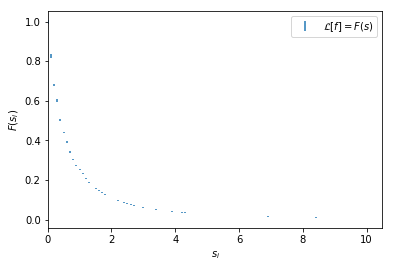

In [6]:
epsilon = 0.01  # 1 percent noise
s_data = np.linspace(0, 10, 101)
F_data = laplace_model(s=s_data).F
F_sigma = epsilon * F_data
np.random.seed(2)
F_data = np.random.normal(F_data, F_sigma)

plt.errorbar(s_data, F_data, yerr=F_sigma, fmt='none', label=r'$\mathcal{L}[f] = F(s)$')
plt.xlabel(r'$s_i$')
plt.ylabel(r'$F(s_i)$')
plt.xlim(0, None)
plt.legend()


We will now invert this data, using the procedure outlined in \cite{}.


In [7]:
N_s = symbols('N_s', integer=True)  # Number of s_i points

M = MatrixSymbol('M', N_s, N_s)
W = MatrixSymbol('W', N_s, N_s)
Fs = MatrixSymbol('Fs', N_s, 1)
c = MatrixSymbol('c', N_s, 1)
d = MatrixSymbol('d', 1, 1)
I = MatrixSymbol('I', N_s, N_s)
a, = parameters('a')

model_dict = {
    W: Inverse(I + M / a**2),
    c: - W * Fs,
    d: sqrt(c.T * c),
}
tikhonov_model = CallableModel(model_dict)
print(tikhonov_model)

[W(I, M; a) = (I + a**(-2)*M)**(-1),
 c(Fs, W; ) = -W*Fs,
 d(c; ) = (c.T*c)**(1/2)]


A ``CallableModel`` is needed because derivatives of matrix expressions sometimes cause problems.


Build required matrices, ignore s=0 because it causes a singularity.


In [8]:
I_mat = np.eye(len(s_data[1:]))
s_i, s_j = np.meshgrid(s_data[1:], s_data[1:])
M_mat = 1 / (s_i + s_j)
delta = np.atleast_2d(np.linalg.norm(F_sigma))
print('d', delta)


d [[0.01965714]]


Perform the fit


In [10]:
model_data = {
	I.name: I_mat,
	M.name: M_mat,
	Fs.name: F_data[1:],
} 
all_data = dict(**model_data, **{d.name: delta})


In [22]:
fit = Fit(tikhonov_model, **all_data)
fit_result = fit.execute()
print(fit_result)



Parameter Value        Standard Deviation
a         5.449374e-02 None
Status message         Optimization terminated successfully.
Number of iterations   14
Objective              <symfit.core.objectives.LeastSquares object at 0x000002B51BEDA390>
Minimizer              <symfit.core.minimizers.BFGS object at 0x000002B51AB3A518>

Goodness of fit qualifiers:
chi_squared            3.3130494560395173e-19
objective_value        1.6565247280197586e-19
r_squared              -inf


Check the quality of the reconstruction


(100,) (100,)


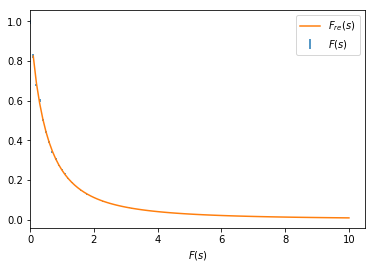

In [23]:
ans = tikhonov_model(**model_data, **fit_result.params)
F_re = - M_mat.dot(ans.c) / fit_result.value(a)**2
print(ans.c.shape, F_re.shape)

plt.errorbar(s_data, F_data, yerr=F_sigma, label=r'$F(s)$', fmt='none')
plt.plot(s_data[1:], F_re, label=r'$F_{re}(s)$')
plt.xlabel(r'$x$')
plt.xlabel(r'$F(s)$')
plt.xlim(0, None)
plt.legend()

Reconstruct $f(t)$ and compare with the known original.


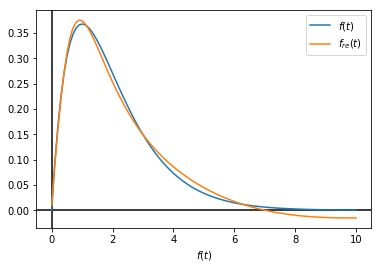

In [25]:
t_data = np.linspace(0, 10, 101)
f_data = model(t=t_data).f
f_re_func = lambda x: - np.exp(- x * s_data[1:]).dot(ans.c) / fit_result.value(a)**2
f_re = [f_re_func(t_i) for t_i in t_data]

plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.plot(t_data, f_data, label=r'$f(t)$')
plt.plot(t_data, f_re, label=r'$f_{re}(t)$')
plt.xlabel(r'$t$')
plt.xlabel(r'$f(t)$')
plt.legend()

Not bad, for an ill-defined problem.
